# Boston House Pricing
## by Aschwin Schilperoort

Welcome to this multiple linear regression notebook! In this notebook we're going to predict the prices of some houses in Boston. House prices are dependent on a lot of factors, like your neighbors, unfortunately knowledge about a hot neighbor is not included... But 80 other variables are! So feature engineering will be fun.

LINK: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

## Importing the libraries

In [1]:
# House Pricing

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LinearRegression
from scipy.stats import norm, skew
from scipy import stats

## Loading the datasets and defining datatypes

In [ ]:
# Importing the datasets
train = pd.read_csv('train.csv') #train.dtypes
test = pd.read_csv('test.csv')

# Making a column name list
columns = list(train.columns.values)

# Making a list of all categorical variables
categorical = list()
for i in columns:
    if train[i].dtype == object:
        categorical.append(i)
del i

# Making a list for numerical variables       
numerical = []
for e in columns:
    if e not in categorical:
        numerical.append(e)       
del e

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

## Data preprocessing
Plotting the data shows some outliers. Now the plots come later, but removing the outliers beforehand solves a lot of issues. So we transferred it to sell three. If you want to see the outliers yourself, skip this cell and plot the results.

### Outliers

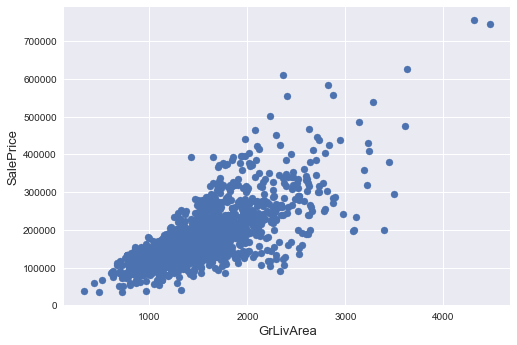

In [3]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


### Normality of the response

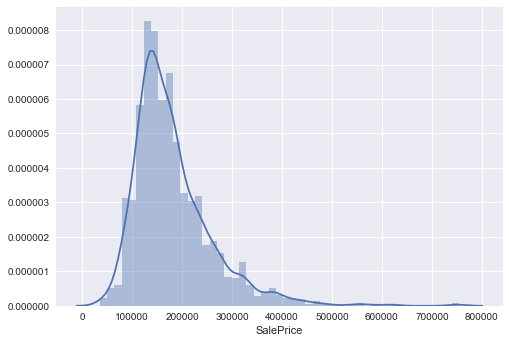

In [4]:
#histogram
sns.distplot(train['SalePrice'])
plt.show()


So we can see that SalesPrice is skewed to the right (positively). We'll use a log transform to make the SalePrice data normally distributed.


 mu = 12.02 and sigma = 0.40



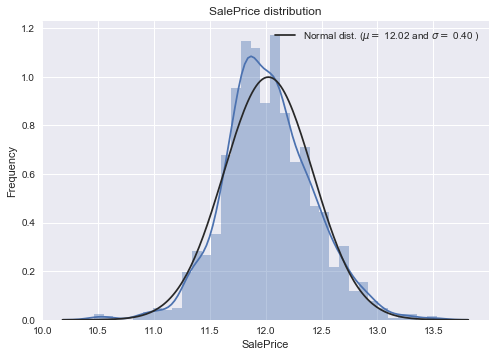

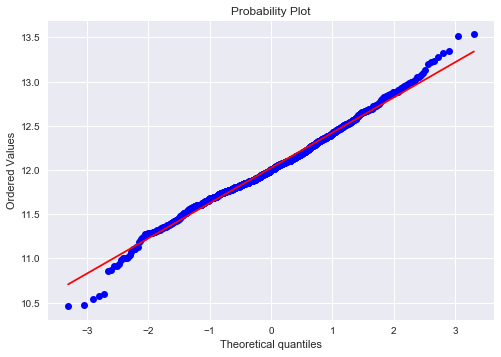

In [5]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

Looks normal enough!

### Correlation
Let's see what SalePrice likes. We want to know what variables are highly correlated with SalePrice. 

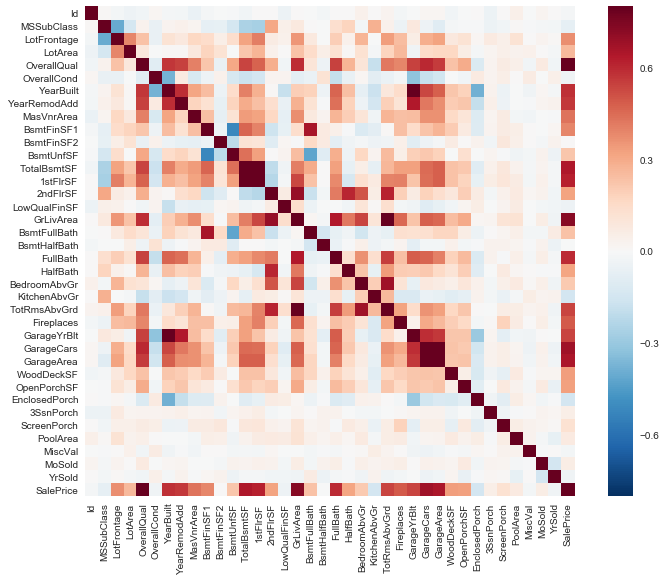

In [6]:
# Correlation Matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat,vmax=0.8, square=True)
plt.show()

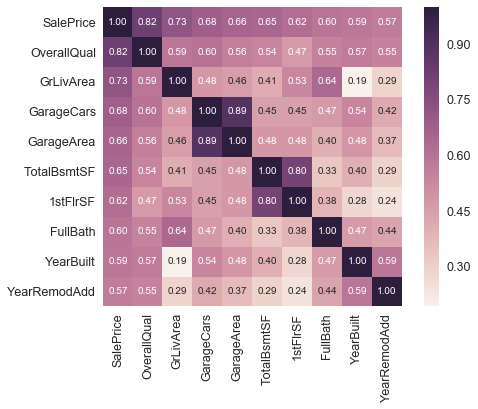

In [7]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

So we can conclude that above variables are highly influential for the SalePrice. We can also conclude from above correlation plots, that some variables are doubles and might have to be removed. GarageCars and GarageArea is a big d0h. 1stFloorSF and BasementSF is another one. apparently the first floor is just as big as the basement unless you have a bunker. So we have to consider removing one of the two.

### Linearity?
Some variables are linear, and some arent! Really? So let's figure out what is what. 

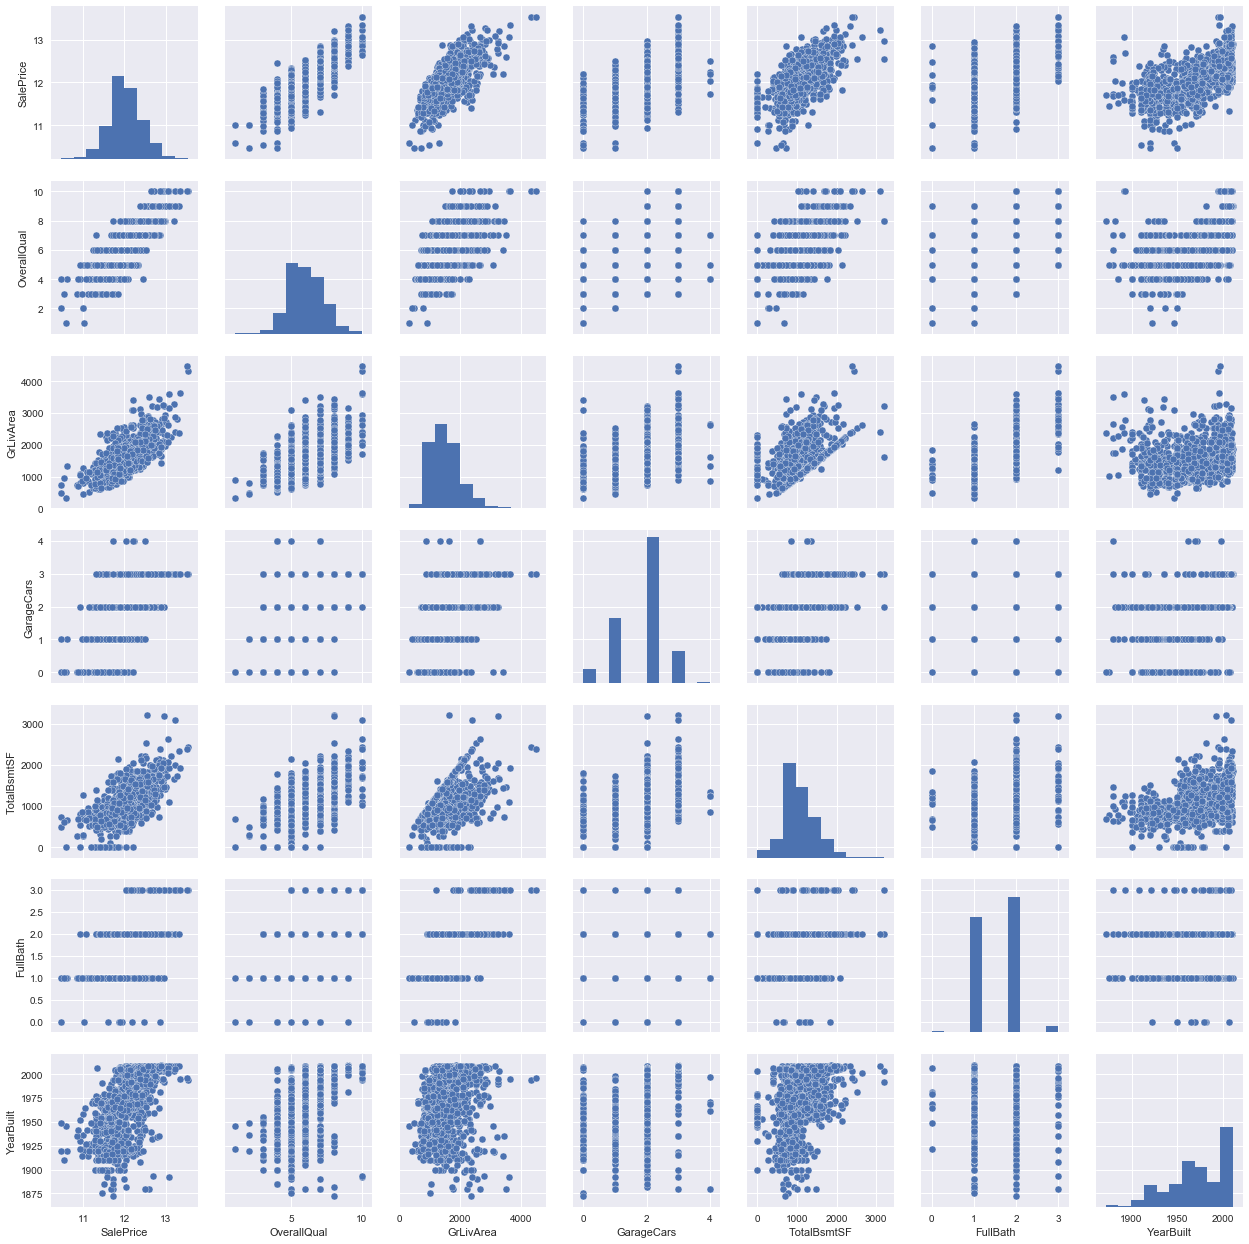

In [8]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show()


In [9]:
# Let's put all the data together in one big data frame.
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
all_data.drop(['Id'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))


all_data size is : (2917, 79)


In [10]:
# Checking for missing data
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageCond,5.450806
GarageFinish,5.450806
GarageYrBlt,5.450806


In [11]:
# Taking care of missing data

# Not all houses have pools, but it's not missing data.
all_data['PoolQC'] = all_data['PoolQC'].fillna("None")

# Not all houses have a Misc Feature, but it's not missing data...
all_data['MiscFeature'] = all_data['MiscFeature'].fillna("None")

# Not all houses have an Alley, but it's not missing data...
all_data['Alley'] = all_data['Alley'].fillna("None")

# Not all houses have a fence
all_data['Fence'] = all_data['Fence'].fillna("None")

# Not all houses have a fireplace...
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna("None")

#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)    
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
    
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

all_data = all_data.drop(['Utilities'], axis=1)

all_data["Functional"] = all_data["Functional"].fillna("Typ")

all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()



,Missing Ratio


In [12]:
# test cell


In [13]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

# Adding above variabeles to our categorical variable.
categorical.extend(['MSSubClass','OverallCond','YrSold','MoSold'])
categorical


['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition',
 'MSSubClass',
 'OverallCond',
 'YrSold',
 'MoSold']

In [14]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [15]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 79)


In [16]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [17]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 59 skewed numerical features to Box Cox transform


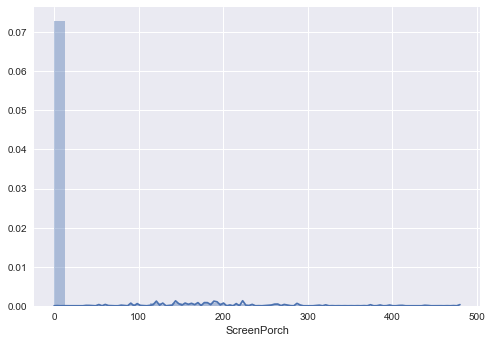

In [18]:
# a test cell: histogram
sns.distplot(train['ScreenPorch'])
plt.show()

In [19]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


In [20]:
train = all_data[:ntrain]
test = all_data[ntrain:]

Time to make dem Models!

In [21]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [22]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [23]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,nthread = -1)

In [24]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1160 (0.0060)



In [43]:
model_xgb.fit(train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.4603,
       gamma=0.0468, learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1.7817, missing=None, n_estimators=2200,
       nthread=-1, objective='reg:linear', reg_alpha=0.464,
       reg_lambda=0.8571, scale_pos_weight=1, seed=0, silent=1,
       subsample=0.5213)

In [46]:
xgb_train_pred = model_xgb.predict(train)

In [47]:
xgb_pred = np.expm1(model_xgb.predict(test))

In [49]:
xgb_pred

array([ 123384.421875 ,  165504.21875  ,  187040.3125   , ...,
        167803.796875 ,  119187.1328125,  227876.421875 ], dtype=float32)

In [51]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = xgb_pred
sub.to_csv('submission.csv',index=False)